In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [16]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- kaggle.house$getCombinedDataset(data$train, data$test)

trainset <- 
    df.combined %>% 
    filter(dataSource == "train") %>%
    mutate(price = SalePrice, log.price = log(SalePrice)) %>%
    select(-dataSource, -SalePrice)

trainset %>% nrow

[1] 1460

In [18]:
trainset.cat <- 
    trainset %>% 
    select(one_of(union(kaggle.house$getCategoricalColumnNames(.), 
           c("price", "log.price"))))

trainset.num <- 
    trainset %>% select_if(is.numeric)

trainset.cat %>% colnames
trainset.num %>% colnames

stopifnot(
    length(trainset.cat %>% select(-price, -log.price)) + length(trainset.num) == length(trainset)
)

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"      "CentralAir"   
 [9] "Condition1"    "Condition2"    "Electrical"    "ExterCond"    
[13] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[17] "FireplaceQu"   "Foundation"    "Functional"    "GarageCond"   
[21] "GarageFinish"  "GarageQual"    "GarageType"    "Heating"      
[25] "HeatingQC"     "HouseStyle"    "KitchenQual"   "LandContour"  
[29] "LandSlope"     "LotConfig"     "LotShape"      "MasVnrType"   
[33] "MiscFeature"   "MSSubClass"    "MSZoning"      "Neighborhood" 
[37] "PavedDrive"    "PoolQC"        "RoofMatl"      "RoofStyle"    
[41] "SaleCondition" "SaleType"      "Street"        "Utilities"    
[45] "price"         "log.price"

[1] "LotFrontage"   "LotArea"       "OverallQual"   "OverallCond"  
 [5] "YearBuilt"     "YearRemodAdd"  "MasVnrArea"    "BsmtFinSF1"   
 [9] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "X1stFlrSF"    
[13] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[17] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[21] "KitchenAbvGr"  "TotRmsAbvGrd"  "Fireplaces"    "GarageYrBlt"  
[25] "GarageCars"    "GarageArea"    "WoodDeckSF"    "OpenPorchSF"  
[29] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[33] "MiscVal"       "MoSold"        "YrSold"        "price"        
[37] "log.price"

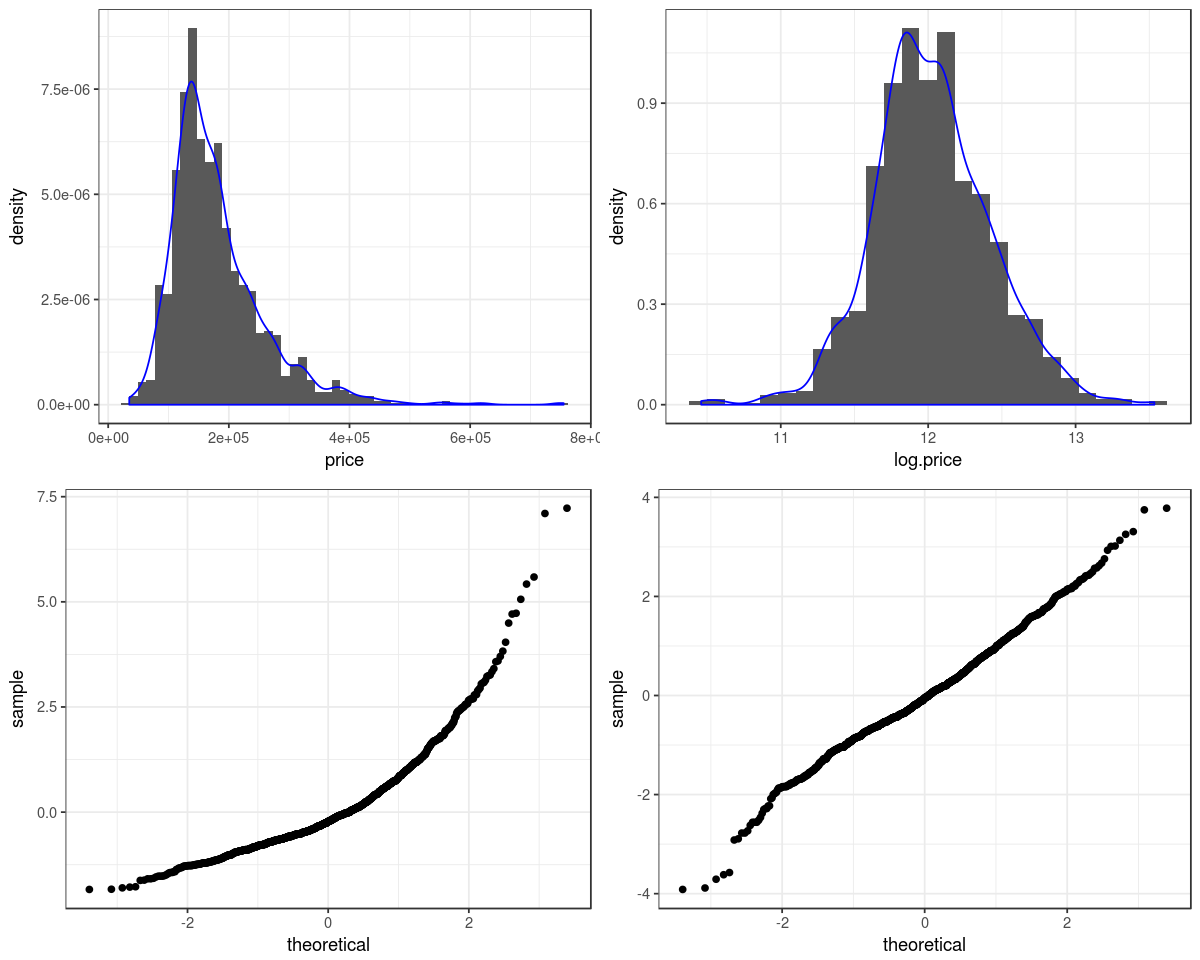

In [19]:
p1 <- trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3) +
    geom_density(color="blue") +
    theme_bw()

p2 <- trainset %>% 
    ggplot(aes(log.price)) +
    geom_histogram(aes(y=..density..), binwidth=0.12) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% 
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm)) +
    theme_bw()

qq2 <- trainset %>% 
    mutate(
        log.price.norm = (log.price - mean(log.price)) / sd(log.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=log.price.norm)) +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 8)

grid.arrange(p1, p2, qq1, qq2, layout_matrix=rbind(c(1, 2), c(3, 4)))

In [92]:
log.price.vs.cat <- 
    trainset.cat %>%
    gather(var.name, var.value, -price, -log.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log) %>%
    arrange(desc(r2.log))

log.price.vs.cat %>% filter(r2.log > 0.09) %>% t

var.name,Neighborhood,ExterQual,PoolQC,KitchenQual,BsmtQual,MSSubClass,GarageFinish,Foundation,GarageType,HeatingQC,⋯,Exterior2nd,SaleCondition,MiscFeature,CentralAir,SaleType,FireplaceQu,BsmtExposure,HouseStyle,Electrical,PavedDrive
r2,0.54557499,0.47738778,0.44865140,0.45659862,0.45375607,0.24631597,0.26727636,0.25636840,0.20663840,0.19550049,⋯,0.15382986,0.13549748,0.11460503,0.06316585,0.13728749,0.11314190,0.13041556,0.08631263,0.05967305,0.05453973
r2.log,0.57080777,0.46112196,0.46020109,0.44763969,0.43537703,0.33012710,0.32345223,0.30365110,0.26922005,0.23351736,⋯,0.17146255,0.12901981,0.12513866,0.12362269,0.12011542,0.11799415,0.11018036,0.10209653,0.09652262,0.09322669


In [94]:
log.price.vs.num <- 
    trainset.num %>%
    gather(var.name, var.value, -price, -log.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log) %>%
    arrange(desc(r2.log))

log.price.vs.num %>% filter(r2.log > 0.09) %>% t

var.name,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,X1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1,LotFrontage,WoodDeckSF,OpenPorchSF,X2ndFlrSF,HalfBath
r2,0.62565189,0.50214865,0.41012394,0.38866676,0.37648109,0.36705687,0.31434385,0.27342162,0.25715139,0.23654768,0.28486041,0.21802254,0.22799961,0.14932027,0.12376260,0.10524408,0.09976516,0.10197408,0.08071717
r2.log,0.66779037,0.49129817,0.46325013,0.42365461,0.37470800,0.35638637,0.35375200,0.34406465,0.31991222,0.29275984,0.28560709,0.23956074,0.18559598,0.13840117,0.12664949,0.11164625,0.10307501,0.10195248,0.09858485


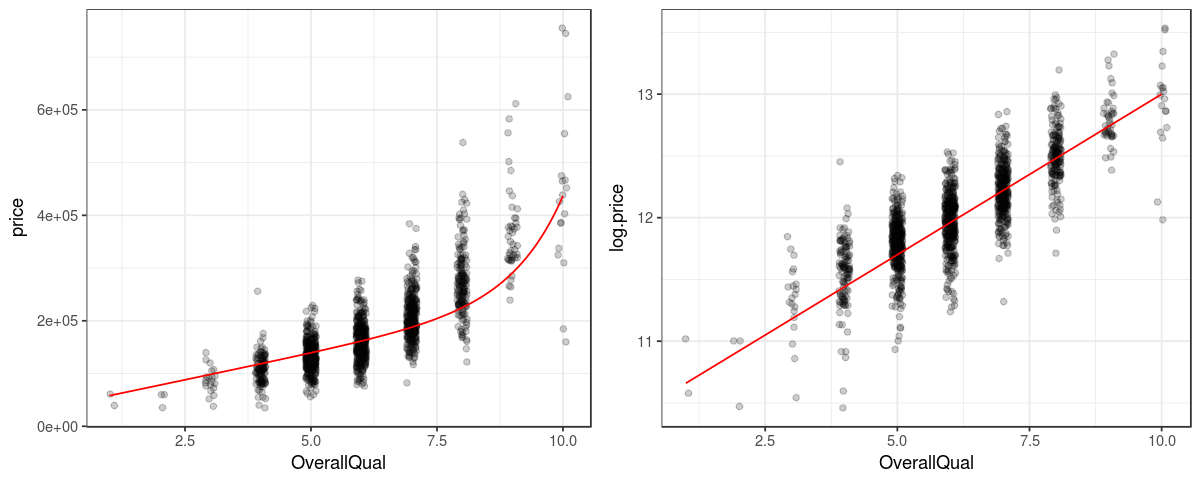

In [136]:
options(repr.plot.width = 10, repr.plot.height = 4)

p1 <- 
    trainset %>%
    ggplot() +
    geom_jitter(aes(x=OverallQual, y=price), alpha=0.2, width=0.1, height=0) +
    stat_function(fun = function (x) { 2e4*x + exp(x + 2.2) + 3.8e4 }, colour = "red") +
    theme_bw()

p2 <- 
    trainset %>%
    ggplot() +
    geom_jitter(aes(x=OverallQual, y=log.price), alpha=0.2, width=0.1, height=0) +
    stat_function(fun = function (x) { 0.26*x + 10.4 }, colour = "red") +
    theme_bw()

grid.arrange(p1, p2,layout_matrix=rbind(c(1, 2)))

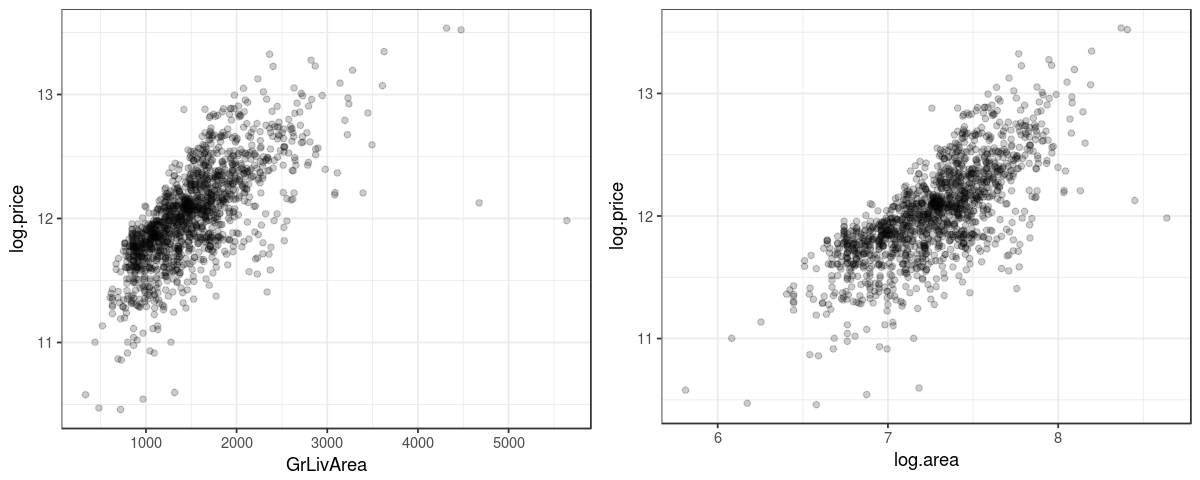

In [143]:
p1 <- 
    trainset %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=log.price), alpha=0.2) +
    theme_bw()

p2 <- 
    trainset %>%
    mutate(log.area = log(GrLivArea)) %>%
    ggplot() +
    geom_point(aes(x=log.area, y=log.price), alpha=0.2) +
    theme_bw()

grid.arrange(p1, p2,layout_matrix=rbind(c(1, 2)))

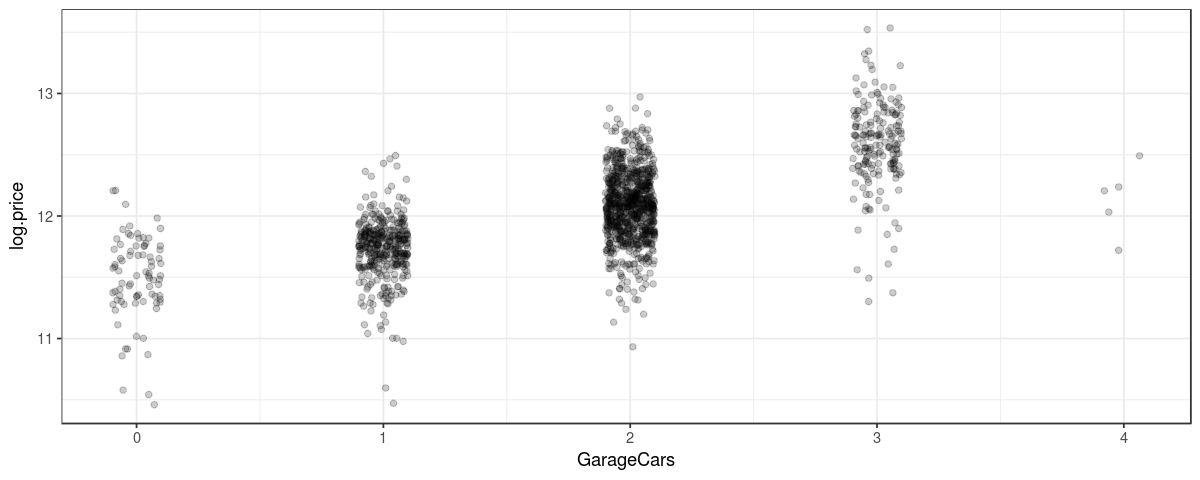

In [144]:
trainset %>%
    ggplot() +
    geom_jitter(aes(x=GarageCars, y=log.price), alpha=0.2, width=0.1, height=0) +
    theme_bw()

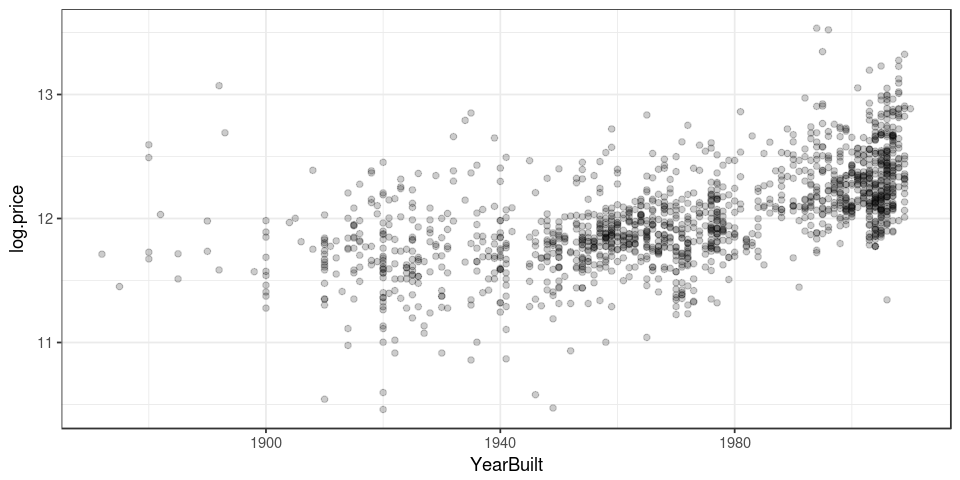

In [134]:
trainset %>%
    mutate(log.price = log(SalePrice)) %>%
    ggplot() +
    geom_point(aes(x=YearBuilt, y=log.price), alpha=0.2) +
    theme_bw()